In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

# Available ACS Tables

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = (tables.table_id.str.contains('acs') &
        ~tables.table_id.str.contains('group') &
        ~tables.table_id.str.contains('level') &
        tables.row_count.between(190000, 220000))
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
49,acs_with_geo_2014,216330
50,fcc_acs_with_geo_2014,216330
40,acs_with_geo_2015,216321
41,acs_with_geo_2016,216321
42,fcc_acs_with_geo_2015,216321
43,fcc_acs_with_geo_2016,216321
58,acs_education,212249
59,acs_school_enrollment,212249
57,acs_hispanic,212247
90,acs_employment,207265


# census_block, left join fcc and acs attributes

In [83]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , block.total_length 
    , block.land_area
    , block.elevation_mean
    , block.elevation_range
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , fcc_demography.population_2016
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
    , SUM(total_length) AS road_length
    , SUM(land_area) AS land_area
    , AVG(elevation_mean) AS avg_elevation
    , AVG(elevation_range) AS avg_elevation_range
  FROM block_level
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.int_avail_per
  , block_group_level.avg_elevation
  , block_group_level.avg_elevation_range
  , SAFE_DIVIDE(block_group_level.road_length, block_group_level.land_area) AS road_density
  , SAFE_DIVIDE(acs_blockgroup_2016.race_total, block_group_level.road_length) * 1000 AS population_density
  , SAFE_DIVIDE(acs_housing_unit.estimate_total, block_group_level.land_area)  * 1000 AS housing_density
  , CAST(acs_blockgroup_2016.median_household_income_in_the_past_12_months AS FLOAT64) AS median_income
  , acs_education_average.avg_years_of_edu
  , acs_employment_percentage.unemployment_rate
  , acs_gender_age.avg_age
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN broadband.acs_blockgroup_2016
  ON block_group_level.block_group = acs_blockgroup_2016.block_group_code
LEFT JOIN broadband.acs_housing_unit
  ON block_group_level.block_group = acs_housing_unit.block_group_code
LEFT JOIN broadband.acs_education_average
  ON block_group_level.block_group = acs_education_average.block_group_code
LEFT JOIN broadband.acs_employment_percentage
  ON block_group_level.block_group = acs_employment_percentage.block_group_code
LEFT JOIN broadband.acs_gender_age
  ON block_group_level.block_group = acs_gender_age.block_group_code
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
"""

all_data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [87]:
all_data.shape

(215566, 11)

In [88]:
# # law category to wide
# categories = pd.get_dummies(all_data.law_type, prefix='law').iloc[:, :-1]
# all_data = all_data.drop(columns='law_type').join(categories)

### Data clean up

In [89]:
all_data.count() / all_data.shape[0] * 100

int_avail_per          100.000000
avg_elevation          100.000000
avg_elevation_range    100.000000
road_density            99.997681
population_density      99.959641
housing_density         92.112392
median_income           99.968455
avg_years_of_edu        96.274459
unemployment_rate       93.894213
avg_age                 92.077600
laws_against           100.000000
dtype: float64

In [90]:
data = all_data.dropna()

In [91]:
# removing the data that does not make sense such as income < 0

mask = (
    (existing_data.avg_elevation_range < existing_data.avg_elevation_range.quantile(0.98)) &
    (existing_data.road_density < existing_data.road_density.quantile(0.99)) &
    (existing_data.road_density > 0 ) &
    (existing_data.population_density < existing_data.population_density.quantile(0.98)) &
    (existing_data.unemployment_rate <= 1) &
    (existing_data.median_income >= 0)
    
)
existing_data = existing_data[mask]

In [92]:
existing_data.housing_density.describe()

count    1.839240e+05
mean     6.322411e-05
std      9.833455e-05
min      9.853360e-09
25%      6.830135e-06
50%      3.478825e-05
75%      7.823873e-05
max      2.245857e-03
Name: housing_density, dtype: float64

avg_elevation
avg_elevation_range
road_density
population_density
median_income
housing_density
avg_years_of_edu
unemployment_rate
avg_age


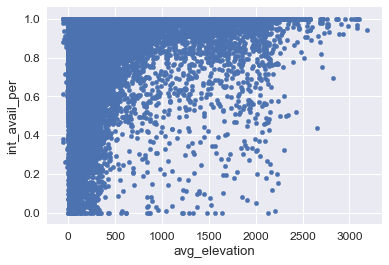

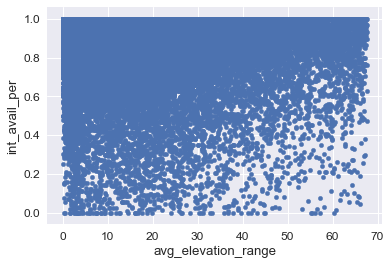

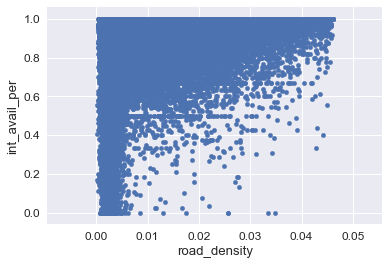

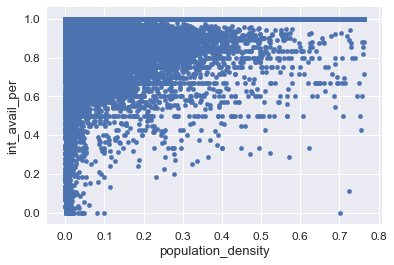

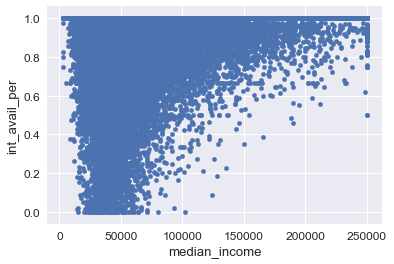

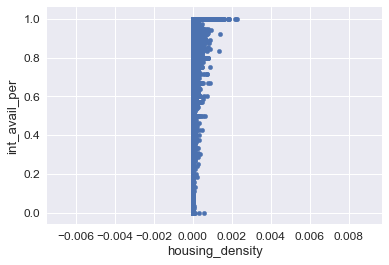

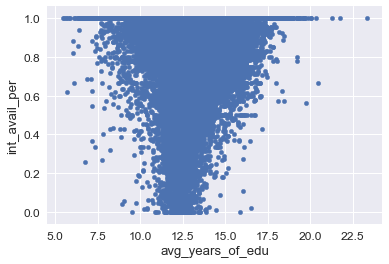

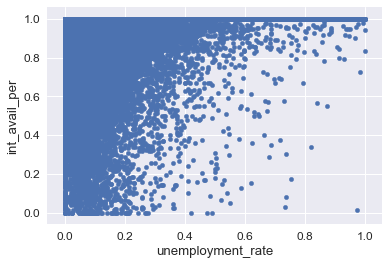

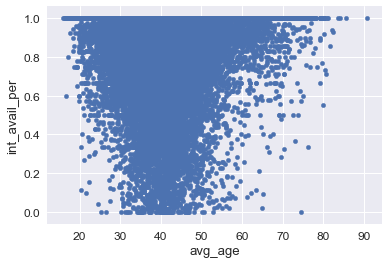

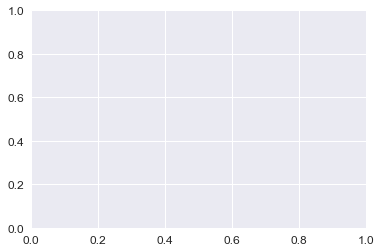

In [93]:
for col in existing_data.columns[1:]:
    try:
        existing_data.plot(x=col, y='int_avail_per', kind='scatter')
        print(col)
    except KeyError:
        pass

Text(0.5,0,'Internet availability percentage')

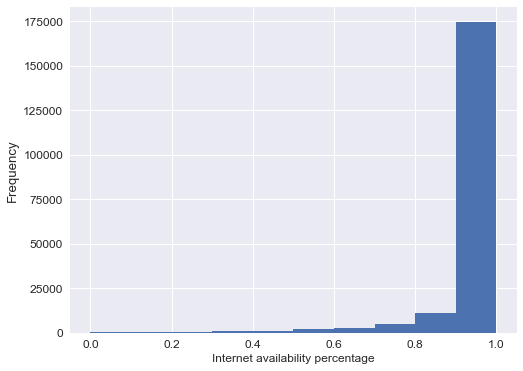

In [94]:
ax = data.int_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [95]:
data.int_avail_per.describe()

count    198059.000000
mean          0.960428
std           0.112695
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: int_avail_per, dtype: float64

In [98]:
full_coverage = (data.int_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', full_coverage)
print('block_group without full coverage', 100 - full_coverage)

block_group with full coverage 76.5135641399785
block_group without full coverage 23.4864358600215


# Correlation Analysis

Removing ethnicity & NA

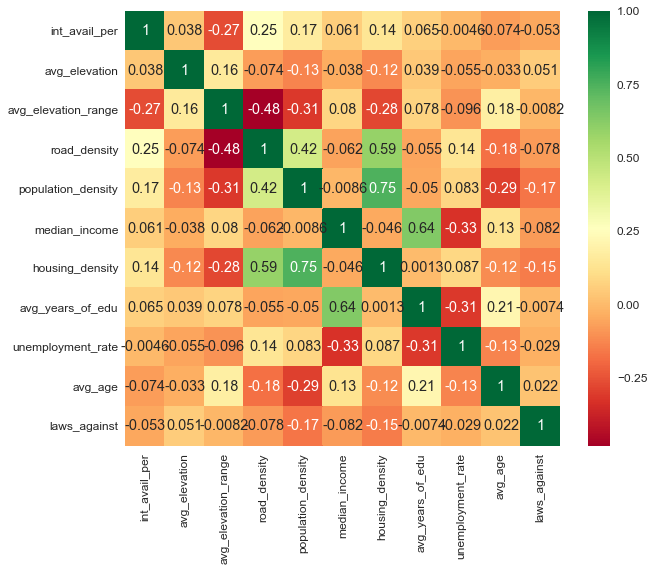

In [99]:
corr = existing_data.corr()

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax, cmap='RdYlGn', square=True, annot=True)

# Model

In [101]:
existing_data.int_avail_per = (existing_data.int_avail_per == 1)

In [110]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

X = existing_data.drop(columns='int_avail_per')
y = existing_data['int_avail_per']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier(max_depth=50, min_samples_split=40)

model.fit(X_train, y_train)

print('Train score', model.score(X_train, y_train))
print('Test score', model.score(X_test, y_test))

Train score 0.8642508104581382
Test score 0.8112817724616012


In [116]:
params = {
#     'n_estimators': [200, 500, 1000],
    'min_samples_split': [55, 60, 65, 70],
    'max_depth': [90, 100, 120],
}

grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=3, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

print('Train score', grid_search.score(X_train, y_train))
print('Test score', grid_search.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   53.0s finished


Train score 0.9037795400014139
Test score 0.8861545576163973


In [117]:
grid_search.best_params_

{'max_depth': 120, 'min_samples_split': 70}

In [118]:
coefficients = pd.DataFrame(list(zip(X.columns, grid_search.best_estimator_.feature_importances_))
                            , columns=['feature', 'gini_coef'])
coefficients.sort_values('gini_coef', ascending=False)

,feature,gini_coef
2,road_density,0.243780
3,population_density,0.210259
1,avg_elevation_range,0.133621
0,avg_elevation,0.129516
4,median_income,0.058099
6,avg_years_of_edu,0.056307
5,housing_density,0.054411
8,avg_age,0.051796
7,unemployment_rate,0.043263
9,laws_against,0.018949
